In [1]:
import numpy as np

# the flow matrix which is the wegiht matrix in our case
f = np.array([[0, 5, 0, 0, 2],
              [1, 0, 1, 2, 0],
              [0, 0, 0, 2, 0],
              [0, 0, 0, 0, 3],
              [0, 0, 0, 0, 0]])

# the distance matrix which is the cost matrix for our case
alpha = 1
beta = 4
gamma = 2


# the above value is taken from the setup 4
d = np.array([[gamma, beta , beta , beta],
             [0, gamma, beta, beta],
             [alpha, 0, gamma, beta],
             [alpha, alpha, 0, gamma]])

In [2]:
n = f.shape[0]
m = d.shape[0]
print(n,m)

5 4


# Generalization

In [3]:
def create_qubo(f, d):
    # defining the value of m and n
    n = f.shape[0] # number of packages
    m = d.shape[0] # number of layers

    # initialize Q matrix with zeros
    # Q matrix is the matrix which will help us to minimize the function
    Q = np.zeros((n*m, n*m))

    # the objective function part
    for i in range(n):
        for j in range(n):
            for k in range(m):
                for l in range(m):
                    # i*m is done to shift the row and k is added as it is an kronecker produt 
                    idx_1 = i * m + k
                    # it is same as above but in the column
                    idx_2 = j * m + l
                    Q[idx_1, idx_2] += f[i, j] * d[k, l] # assigning the values

    A = 10  # penalty coefficient (can be anything)
                   
    for i in range(n):
        for k in range(m):
            idx_i = i * m + k  # # indexing for the penalty term i.e sum(xij) = 1
            # we add this value after the expansion of the penalty term 
            # and according to the index of the variable x
            Q[idx_i, idx_i] += -2 * A
            for l in range(k + 1, m):
                idx_l = i * m + l  
                # this is added because we have the terms like 2A(x_ik ** 2)
                Q[idx_i, idx_l] += A

    # additional penalty to enforce each package being assigned to exactly one location
    for i in range(n):
        for k in range(m):
            idx = i * m + k
            for l in range(m):
                if k != l:
                    idx_2 = i * m + l
                    Q[idx, idx_2] += A  # Penalize different assignments within the same package
                else:
                    Q[idx, idx] += -A       

    return Q

Q = create_qubo(f,d)

In [4]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings
import networkx as nx

[[-30.  20.  20.  20.  10.  20.  20.  20.   0.   0.   0.   0.   0.   0.
    0.   0.   4.   8.   8.   8.]
 [ 10. -30.  20.  20.   0.  10.  20.  20.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   4.   8.   8.]
 [ 10.  10. -30.  20.   5.   0.  10.  20.   0.   0.   0.   0.   0.   0.
    0.   0.   2.   0.   4.   8.]
 [ 10.  10.  10. -30.   5.   5.   0.  10.   0.   0.   0.   0.   0.   0.
    0.   0.   2.   2.   0.   4.]
 [  2.   4.   4.   4. -30.  20.  20.  20.   2.   4.   4.   4.   4.   8.
    8.   8.   0.   0.   0.   0.]
 [  0.   2.   4.   4.  10. -30.  20.  20.   0.   2.   4.   4.   0.   4.
    8.   8.   0.   0.   0.   0.]
 [  1.   0.   2.   4.  10.  10. -30.  20.   1.   0.   2.   4.   2.   0.
    4.   8.   0.   0.   0.   0.]
 [  1.   1.   0.   2.  10.  10.  10. -30.   1.   1.   0.   2.   2.   2.
    0.   4.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -30.  20.  20.  20.   4.   8.
    8.   8.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  10. -30.  20

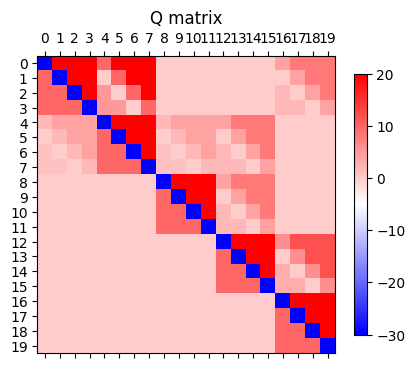

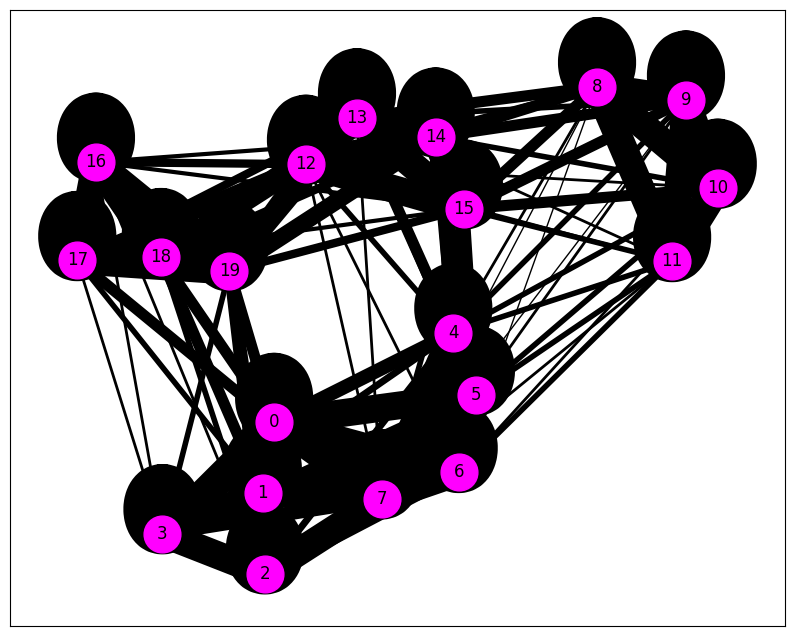

In [6]:
print(f'{Q} = Q matrix')
n = len(Q[0])
dim = 2**n

def plot_Q_matrix():
    plt.matshow(Q, cmap='bwr')
    plt.xticks(np.arange(n))
    plt.yticks(np.arange(n))
    cb = plt.colorbar(shrink=0.7)
    plt.title(f'Q matrix') 
    plt.show()

plot_Q_matrix()

'In the graph, a node represents a qubit (binary variables), width of the edge (i,j) is proportional to Q_ij'

plt.subplots(figsize=(10,8))  
g = nx.Graph()

edges = []
for i in range(n):
    for j in range(i, n):
        if Q[i,j]!=0:
            edges.append((i, j, Q[i,j]))
            
g.add_weighted_edges_from(edges)

pos = nx.spring_layout(g, seed=0)
nx.draw_networkx(g, pos, node_size= 700, node_color='magenta', 
                 width=list(nx.get_edge_attributes(g, "weight").values()))

energies for different x = [...E_x...] = [  0. -30. -30. ... 750. 730. 860.]


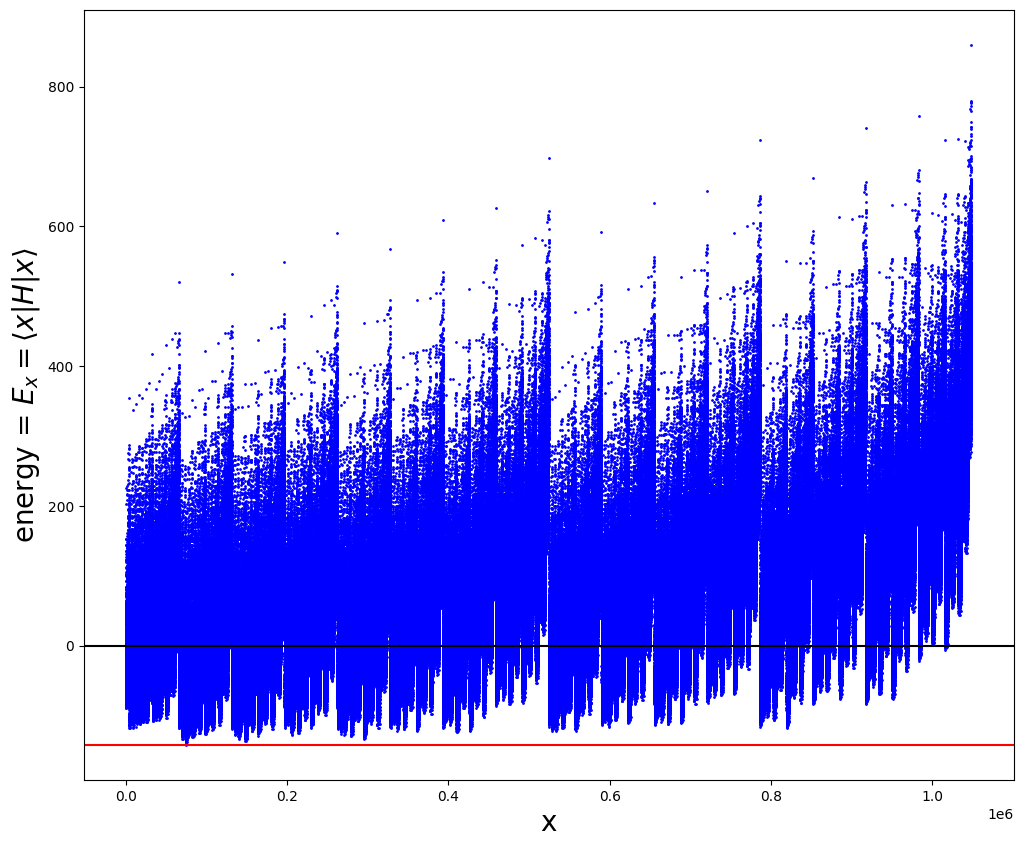

global min_energy = -142.0
global min_energy eigenstates = [74312] = [[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]]

global max_energy = 860.0


In [7]:
def energy(x, Q):                                              # x in an integer, one-to-one correspondence: x <--> x_bin 
    x_bin = np.array([int(i) for i in np.binary_repr(x, n)])   # x_bin has n components, each one is either 0 (spin-up) or 1(spin-down)                                      
    E = np.linalg.multi_dot([x_bin, Q, x_bin])                 # E_x = energy for a given x
    return E
    

def energies(Q):
    n = Q.shape[0]                  # number of qubits
    dim = 2**n                      # dimension of the n-qubit Hilbert space
    xE = []
    for x in range(dim):                                                                                
        E = energy(x, Q)              
        xE.append([x, E])
    return np.array(xE)             # collection of all possible 2**n energies for different x
 
        
xE = energies(Q=Q)
engs = xE[:,1] 
print(f'energies for different x = [...E_x...] = {engs}')


min_eng = np.min(engs)
max_eng = np.max(engs)

plt.rcParams["figure.figsize"] = (12,10)
plt.scatter(np.arange(dim), engs, s=1, c='blue')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = min_eng, color = 'red', linestyle = '-')
plt.ylabel(r'energy = $E_x = \langle x|H|x\rangle$', fontsize=20)
plt.xlabel('x', fontsize=20)
plt.show()

xmins = np.where(engs==min_eng)[0]
xmins_bin = [[int(i) for i in np.binary_repr(xmin, n)] for xmin in xmins]

print(f'global min_energy = {min_eng}')
print(f'global min_energy eigenstates = {xmins} = {xmins_bin}\n')
print(f'global max_energy = {max_eng}')

In [9]:
from qiskit_optimization import QuadraticProgram                         #!pip install qiskit[optimization]
from qiskit_aer import Aer
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE, QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer


from qiskit.primitives import Sampler
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA, COBYLA

In [10]:
qp = QuadraticProgram()

for i in range(n):
    qp.binary_var(f'x{i}')

    
linear = [Q[i,i] for i in range(n)]

quadratic = {}
for i in range(n):
    for j in range(i+1, n):
        quadratic[(f'x{i}', f'x{j}')] = Q[i,j]
        

qp.minimize(linear=linear, quadratic=quadratic)
qp

<QuadraticProgram: minimize 20*x0*x1 + 4*x0*x16 + 8*x0*x17 + 8*x0*x18 + 8*x0*x..., 20 variables, 0 constraints, ''>

In [11]:
exact = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())
print()

objective function value: -154.0
variable values: x0=0.0, x1=0.0, x2=0.0, x3=1.0, x4=0.0, x5=0.0, x6=1.0, x7=0.0, x8=0.0, x9=1.0, x10=1.0, x11=0.0, x12=0.0, x13=1.0, x14=0.0, x15=0.0, x16=1.0, x17=1.0, x18=0.0, x19=0.0
status: SUCCESS

